<a href="https://colab.research.google.com/github/taxfree-python/iGEM_2022_Dry-Prediction/blob/main/Singapore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from keras import metrics
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import model_to_dot

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
# from sklearn.model_selection import GridSearchCV

import lightgbm as lgb

from IPython.display import SVG

from google.colab import files
import copy
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
# !pip freeze > requirements.txt

In [ ]:
cases = pd.read_csv('drive/MyDrive/dry/modeling/data/Singapore/cases.csv',  index_col = 0)
cases[cases.columns[0]] = pd.to_datetime(cases[cases.columns[0]], format = '%Y-%m')

In [ ]:
climate = pd.read_csv('drive/MyDrive/dry/modeling/data/Singapore/climate_edit_rainfall.csv',  index_col = 0)
climate.drop(climate.index[54], inplace = True)
climate_temp = copy.deepcopy(climate)

scaler_climate = MinMaxScaler()
scaler_climate.fit(climate[climate.columns[1:]])
climate = pd.DataFrame(scaler_climate.transform(climate[climate.columns[1:]]), columns = climate.columns[1:])

date = [f'{i}-{j}' for i in range(2018, 2023) for j in range(1, 13)][:54]
climate.insert(0, 'date', date)
climate[climate.columns[0]] = pd.to_datetime(climate[climate.columns[0]], format = '%Y-%m')

In [ ]:
# climate = pd.read_csv('drive/MyDrive/dry/modeling/data/Singapore/climate_edit_rainfall.csv',  index_col = 0)
# climate.drop(climate.index[54], inplace = True)
# climate_temp = copy.deepcopy(climate)

# scaler_climate = MinMaxScaler()
# scaler_climate.fit(climate[climate.columns[1:]])
# climate = pd.DataFrame(scaler_climate.transform(climate[climate.columns[1:]]), columns = climate.columns[1:])

# date = [f'{j}' for i in range(2018, 2023) for j in range(1, 13)][:54]
# climate.insert(0, 'date', date)
# climate[climate.columns[0]] = pd.to_datetime(climate[climate.columns[0]], format = '%m')

# cases = pd.read_csv('drive/MyDrive/dry/modeling/data/Singapore/cases.csv',  index_col = 0)
# cases.drop(cases.columns[0], axis = 1, inplace = True)
# cases.insert(0, 'date', date)
# cases[cases.columns[0]] = pd.to_datetime(cases[cases.columns[0]], format = '%m')

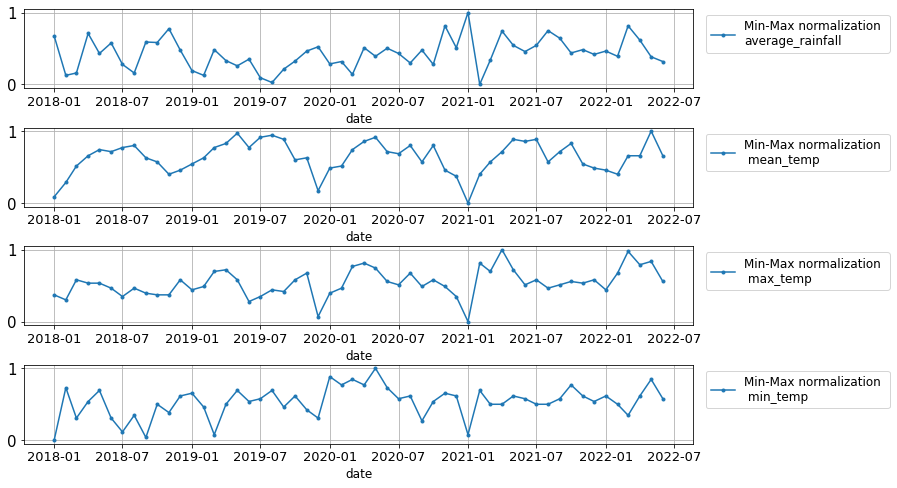

In [ ]:
data = pd.merge(cases, climate)
keys_data = data.columns

fig = plt.figure(figsize = (12, 8))
# for i in range(1, 5):
#     plt.subplots_adjust(wspace=0.2, hspace=0.5)
#     ax = fig.add_subplot(4, 1, i)
#     ax.plot(data[keys_data[0]], data[keys_data[i]], marker='.', label = f'{keys_data[i]}')
#     ax.set_ylabel('ratio(%)', fontsize = 12)
#     ax.set_ylim([0, 100])
#     ax.grid()
#     ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
#     ax.tick_params(axis = 'y', which = 'major', labelsize = 13)
#     ax.set_xlabel('date', fontsize = 12)
#     ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad = 0.5, fontsize = 12)

for i in range(5, len(keys_data)):
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    ax = fig.add_subplot(4, 1, i - 4)
    ax.grid()
    ax.set_xlabel('date', fontsize = 12)
    if i != 5:
        # ax.set_ylim(18, 40)
        # ax.set_ylabel('temperature(℃)', fontsize = 12)
        ax.plot(data[keys_data[0]], data[keys_data[i]], marker='.', label = f'Min-Max normalization \n {keys_data[i]}')
    else:
        # ax.set_ylim(0, 18)
        ax.plot(data[keys_data[0]], data[keys_data[i]], marker='.', label = f'Min-Max normalization \naverage_rainfall')
        # ax.set_ylabel('rainfall(mm)', fontsize = 12)
    if i == 7:
        ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad = 0.5, fontsize = 12)
    else:
        ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad = 0.5, fontsize = 12)
    ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
    ax.tick_params(axis = 'y', which = 'major', labelsize = 15)

data.drop(keys_data[0], inplace = True, axis = 1)
new_index = [[' DENV-1', ' DENV-2', ' DENV-3', ' DENV-4', 'total_rainfall', 'mean_temp', 'max_temp', 'min_temp'],
             [' DENV-2', ' DENV-1', ' DENV-3', ' DENV-4', 'total_rainfall', 'mean_temp', 'max_temp', 'min_temp'],
             [' DENV-3', ' DENV-1', ' DENV-2', ' DENV-4', 'total_rainfall', 'mean_temp', 'max_temp', 'min_temp'],
             [' DENV-4', ' DENV-1', ' DENV-2', ' DENV-3', 'total_rainfall', 'mean_temp', 'max_temp', 'min_temp']]
data = [data.reindex(columns = new_index[i]) for i in range(4)]
data_dropped = [data[i].drop(new_index[i][1:4], axis = 1) for i in range(4)]

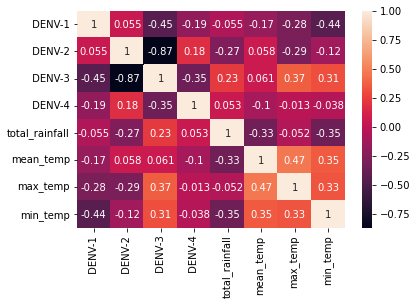

In [ ]:
sns.heatmap(data[0].corr(), annot = True)

In [ ]:
major = climate.loc[[i * 12 for i in range(5)], climate.columns[0]]
minor = climate.loc[[5 + i * 12 for i in range(5)], climate.columns[0]]

In [ ]:
train_data_split, test_data_split = [train_test_split(data[i], shuffle = False, test_size = 0.05)[0].values for i in range(4)], [train_test_split(data[i], shuffle = False, test_size = 0.05)[1].values for i in range(4)]

for i in range(4):
    train_data_split[i][:, :4] = train_data_split[i][:, :4] / 100
    test_data_split[i][:, :4] = test_data_split[i][:, :4] / 100

train_data_dropped_split, test_data_dropped_split = [train_test_split(data_dropped[i], shuffle = False, test_size = 0.05)[0].values for i in range(4)], [train_test_split(data_dropped[i], shuffle = False, test_size = 0.05)[1].values for i in range(4)]

for i in range(4):
    train_data_dropped_split[i][:, :4] = train_data_dropped_split[i][:, :4] / 100
    test_data_dropped_split[i][:, :4] = test_data_dropped_split[i][:, :4] / 100
test_data_dropped_split[0]
train_data_dropped_split[i].shape[0]

51

In [ ]:
#Lasso
climate_temp[climate_temp.columns[0]] = pd.to_datetime(climate_temp[climate_temp.columns[0]], format = '%Y-%m')

data_lasso = pd.merge(cases, climate_temp)
keys_data_lasso = data_lasso.columns

# fig = plt.figure(figsize = (12, 8))
# for i in range(1, len(keys_data_lasso)):
#     ax = fig.add_subplot(4, 2, i)
#     ax.plot(data_lasso[keys_data_lasso[0]], data_lasso[keys_data_lasso[i]], marker='.', label = f'{keys_data_lasso[i]}')
#     ax.legend()

data_lasso.drop(keys_data_lasso[0], inplace = True, axis = 1)
new_index = [[' DENV-1', ' DENV-2', ' DENV-3', ' DENV-4', 'total_rainfall', 'mean_temp', 'max_temp', 'min_temp'],
             [' DENV-2', ' DENV-1', ' DENV-3', ' DENV-4', 'total_rainfall', 'mean_temp', 'max_temp', 'min_temp'],
             [' DENV-3', ' DENV-1', ' DENV-2', ' DENV-4', 'total_rainfall', 'mean_temp', 'max_temp', 'min_temp'],
             [' DENV-4', ' DENV-1', ' DENV-2', ' DENV-3', 'total_rainfall', 'mean_temp', 'max_temp', 'min_temp']]
data_lasso = [data_lasso.reindex(columns = new_index[i]) for i in range(4)]
data_lasso_dropped = [data_lasso[i].drop(new_index[i][1:4], axis = 1) for i in range(4)]
# data_lasso_dropped = data_lasso

train_data_split_lasso, test_data_split_lasso = [train_test_split(data_lasso_dropped[i], shuffle = False, test_size = 0.05)[0].values for i in range(4)], [train_test_split(data_lasso_dropped[i], shuffle = False, test_size = 0.05)[1].values for i in range(4)]
# for i in range(4):
#     train_data_split_lasso[i][:, :4] = train_data_split_lasso[i][:, :4] / 100
#     test_data_split_lasso[i][:, :4] = test_data_split_lasso[i][:, :4] / 100

[17.5948, 779.58799, 1395.49186, 57.89439]


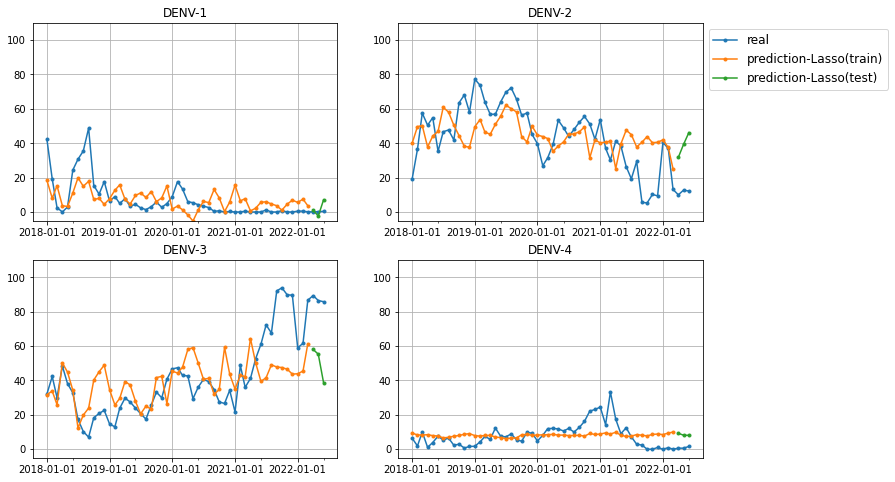

In [ ]:
#using row data

#using Lassocv
method = 'LassoCV'
train_data = train_data_split_lasso
test_data = test_data_split_lasso

alpha_list = []
coef_list = []
intercept_list = []

for serotype in range(1, 5):
    for upper in reversed(range(-6, 1)):
        lassocv = LassoCV(alphas = 10 ** np.arange(-6, upper, 0.1), cv = 5)
        lassocv.fit(train_data[serotype - 1][:, 1:], train_data[serotype - 1][:, 0])
        coef = lassocv.coef_
        if np.count_nonzero(coef) == 4:
            alpha_list.append(lassocv.alpha_)
            coef_list.append(lassocv.coef_)
            intercept_list.append(lassocv.intercept_)
            break

# print(alpha_list, coef_list, intercept_list)

method = 'Lasso'
train_data = train_data_split_lasso
test_data = test_data_split_lasso

predicts_lasso = []
logs_lasso = []
coef = []
fig = plt.figure(figsize = (12, 8))


for serotype in range(1, 5):
    # print(alpha_list[serotype - 1])
    lasso = Lasso(alpha = alpha_list[serotype - 1], max_iter = 100).fit(train_data[serotype - 1][:, 1:], train_data[serotype - 1][:, 0])
    Predict_train = lasso.predict(train_data[serotype - 1][:, 1:])
    Predict_test = lasso.predict(test_data[serotype - 1][:, 1:])
    predicts_lasso.append(np.concatenate([Predict_train, Predict_test]))
    # score.append(lasso.score(test_data[serotype - 1][:, 1:], test_data[serotype - 1][:, 0]))
    coef.append(lasso.coef_)

    predict_train = pd.DataFrame(Predict_train)
    predict_train.insert(0, 'date', date[:51])
    predict_train[predict_train.columns[0]] = pd.to_datetime(predict_train[predict_train.columns[0]], format = '%Y-%m')
    
    predict_test = pd.DataFrame(Predict_test)
    predict_test.insert(0, 'date', [f'2022-{i}' for i in range(4, 7)]) #testにtrain_data[-2,-1]を入れるときはrange(4,7)
    predict_test[predict_test.columns[0]] = pd.to_datetime(predict_test[predict_test.columns[0]], format = '%Y-%m')

    ax = fig.add_subplot(2, 2, serotype)
    ax.plot(cases[cases.columns[0]], cases[cases.columns[serotype]], marker='.', label = 'real')
    ax.plot(predict_train[predict_train.columns[0]], predict_train[predict_train.columns[1]], marker='.', label = f'prediction-{method}(train)')
    ax.plot(predict_test[predict_test.columns[0]], predict_test[predict_test.columns[1]], marker='.', label = f'prediction-{method}(test)')
    ax.set_xticks(major, minor = False)
    ax.set_xticks(minor, minor = True)
    ax.set_ylim(-5, 110)
    if serotype == 2:
        ax.legend(bbox_to_anchor = (1, 1), loc = 'upper left', borderaxespad = 0.5, fontsize = 12)
    ax.grid()
    ax.set_title(f'DENV-{serotype}')
    # ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
    # ax.tick_params(axis = 'y', which = 'major', labelsize = 15)

    logs_lasso.append(round(mean_squared_error(test_data[serotype - 1][:, 0], Predict_test), 5))

coef = np.round(coef, 5)
print(logs_lasso)
# plt.tight_layout()
# plt.savefig('lasso.png', dpi = 300)
# files.download('lasso.png')

[0.00178, 0.078, 0.13961, 0.0057]


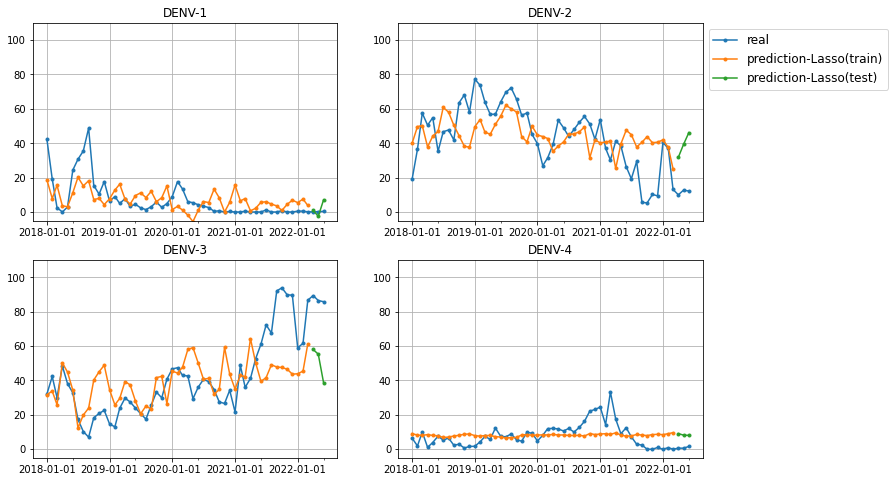

In [ ]:
#scale cases
#using row data

#using Lassocv
method = 'LassoCV'
train_data = train_data_split_lasso
test_data = test_data_split_lasso

alpha_list = []
coef_list = []
intercept_list = []

for serotype in range(1, 5):
    for upper in reversed(range(-6, 1)):
        lassocv = LassoCV(alphas = 10 ** np.arange(-6, upper, 0.1), cv = 5)
        lassocv.fit(train_data[serotype - 1][:, 1:], train_data[serotype - 1][:, 0])
        coef = lassocv.coef_
        if np.count_nonzero(coef) == 4:
            alpha_list.append(lassocv.alpha_)
            coef_list.append(lassocv.coef_)
            intercept_list.append(lassocv.intercept_)
            break


method = 'Lasso'
train_data = train_data_split_lasso
test_data = test_data_split_lasso

predicts_lasso = []
logs_lasso = []
coef = []
fig = plt.figure(figsize = (12, 8))


for serotype in range(1, 5):
    # print(alpha_list[serotype - 1])
    lasso = Lasso(alpha = alpha_list[serotype - 1], max_iter = 100).fit(train_data[serotype - 1][:, 1:], train_data[serotype - 1][:, 0])
    Predict_train = lasso.predict(train_data[serotype - 1][:, 1:])
    Predict_test = lasso.predict(test_data[serotype - 1][:, 1:])
    predicts_lasso.append(np.concatenate([Predict_train, Predict_test]))
    # score.append(lasso.score(test_data[serotype - 1][:, 1:], test_data[serotype - 1][:, 0]))
    coef.append(lasso.coef_)

    predict_train = pd.DataFrame(Predict_train * 100)
    predict_train.insert(0, 'date', date[:51])
    predict_train[predict_train.columns[0]] = pd.to_datetime(predict_train[predict_train.columns[0]], format = '%Y-%m')
    
    predict_test = pd.DataFrame(Predict_test * 100)
    predict_test.insert(0, 'date', [f'2022-{i}' for i in range(4, 7)]) #testにtrain_data[-2,-1]を入れるときはrange(4,7)
    predict_test[predict_test.columns[0]] = pd.to_datetime(predict_test[predict_test.columns[0]], format = '%Y-%m')

    ax = fig.add_subplot(2, 2, serotype)
    ax.plot(cases[cases.columns[0]], cases[cases.columns[serotype]], marker='.', label = 'real')
    ax.plot(predict_train[predict_train.columns[0]], predict_train[predict_train.columns[1]], marker='.', label = f'prediction-{method}(train)')
    ax.plot(predict_test[predict_test.columns[0]], predict_test[predict_test.columns[1]], marker='.', label = f'prediction-{method}(test)')
    ax.set_xticks(major, minor = False)
    ax.set_xticks(minor, minor = True)
    ax.set_ylim(-5, 110)
    if serotype == 2:
        ax.legend(bbox_to_anchor = (1, 1), loc = 'upper left', borderaxespad = 0.5, fontsize = 12)
    ax.grid()
    ax.set_title(f'DENV-{serotype}')
    # ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
    # ax.tick_params(axis = 'y', which = 'major', labelsize = 15)

    logs_lasso.append(round(mean_squared_error(test_data[serotype - 1][:, 0], Predict_test), 5))

coef = np.round(coef, 5)
print(logs_lasso)
# plt.tight_layout()
# plt.savefig('lasso.png', dpi = 300)
# files.download('lasso.png')

[0.05597, 127.66082, 7523.80604, 0.9448]


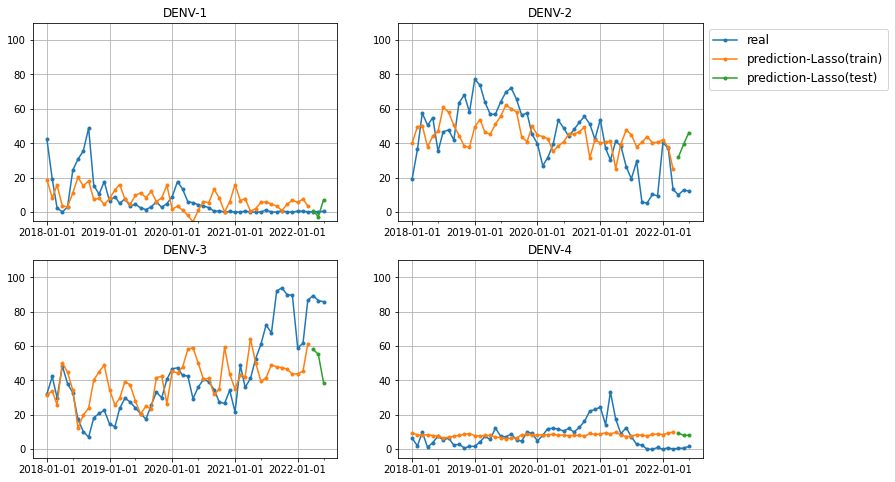

In [ ]:
#using row data
method = 'Lasso'
train_data = train_data_split_lasso
test_data = test_data_split_lasso

predicts_lasso = []
logs_lasso = []
coef = []
fig = plt.figure(figsize = (12, 8))


for serotype in range(1, 5):
    lasso = Lasso(alpha=0.001, max_iter=100).fit(train_data[serotype - 1][:, 1:], train_data[serotype - 1][:, 0])
    Predict_train = lasso.predict(train_data[serotype - 1][:, 1:])
    Predict_test = lasso.predict(test_data[serotype - 1][:, 1:])
    predicts_lasso.append(np.concatenate([Predict_train, Predict_test]))
    # score.append(lasso.score(test_data[serotype - 1][:, 1:], test_data[serotype - 1][:, 0]))
    coef.append(lasso.coef_)

    predict_train = pd.DataFrame(Predict_train)
    predict_train.insert(0, 'date', date[:51])
    predict_train[predict_train.columns[0]] = pd.to_datetime(predict_train[predict_train.columns[0]], format = '%Y-%m')
    
    predict_test = pd.DataFrame(Predict_test)
    predict_test.insert(0, 'date', [f'2022-{i}' for i in range(4, 7)]) #testにtrain_data[-2,-1]を入れるときはrange(4,7)
    predict_test[predict_test.columns[0]] = pd.to_datetime(predict_test[predict_test.columns[0]], format = '%Y-%m')

    ax = fig.add_subplot(2, 2, serotype)
    ax.plot(cases[cases.columns[0]], cases[cases.columns[serotype]], marker='.', label = 'real')
    ax.plot(predict_train[predict_train.columns[0]], predict_train[predict_train.columns[1]], marker='.', label = f'prediction-{method}(train)')
    ax.plot(predict_test[predict_test.columns[0]], predict_test[predict_test.columns[1]], marker='.', label = f'prediction-{method}(test)')
    ax.set_xticks(major, minor = False)
    ax.set_xticks(minor, minor = True)
    ax.set_ylim(-5, 110)
    if serotype == 2:
        ax.legend(bbox_to_anchor = (1, 1), loc = 'upper left', borderaxespad = 0.5, fontsize = 12)
    ax.grid()
    ax.set_title(f'DENV-{serotype}')
    # ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
    # ax.tick_params(axis = 'y', which = 'major', labelsize = 15)

    Predict_test = Predict_test / 100
    logs_lasso.append(round(mean_squared_error(test_data[serotype - 1][:, 0], Predict_test), 5))

coef = np.round(coef, 5)
print(logs_lasso)
# plt.tight_layout()
# plt.savefig('lasso.png', dpi = 300)
# files.download('lasso.png')

In [ ]:
coef

array([[-0.     , -0.     , -0.     , -0.08172],
       [-0.87947,  0.     , -0.     , -0.03603],
       [ 1.53407, -0.     ,  0.     ,  0.13446],
       [ 0.     , -0.     ,  0.     ,  0.     ]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

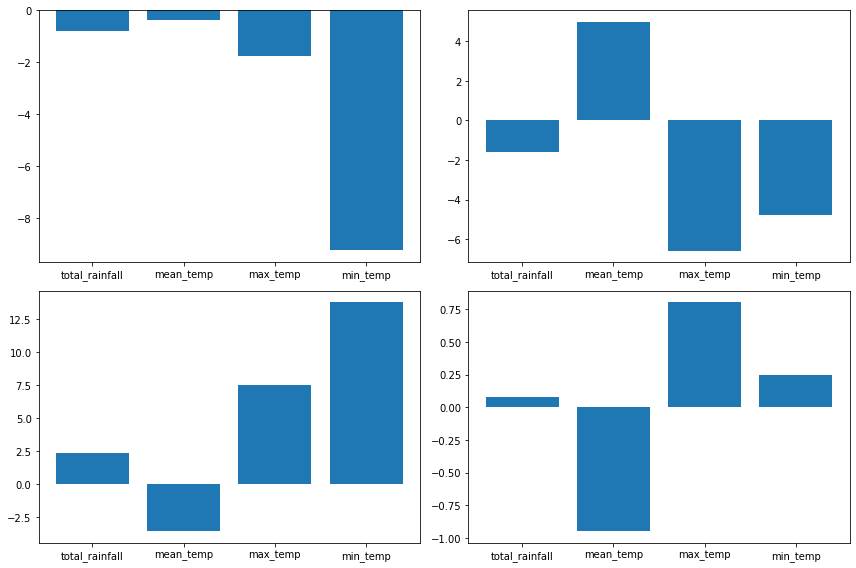

In [ ]:
fig = plt.figure(figsize = (12, 8))
for i in range(4):
    ax = fig.add_subplot(2, 2, i + 1)
    ax.bar(climate.columns[1:], coef[i])
plt.tight_layout()
plt.savefig('lasso_coef.png', dpi = 300)
files.download('lasso_coef.png')

In [ ]:
#using normalized data
train_data = train_data_split
test_data = test_data_split

predicts_lasso_normal = []
score_normal = []
coef_normal = []
fig = plt.figure(figsize = (12, 8))

alpha_list = []
coef_list = []
intercept_list = []

for serotype in range(1, 5):
    for upper in reversed(range(-6, 1)):
        lassocv = LassoCV(alphas = 10 ** np.arange(-6, upper, 0.1), cv = 5)
        lassocv.fit(train_data[serotype - 1][:, 1:], train_data[serotype - 1][:, 0])
        coef = lassocv.coef_
        if np.count_nonzero(coef) == 4:
            alpha_list.append(lassocv.alpha_)
            coef_list.append(lassocv.coef_)
            intercept_list.append(lassocv.intercept_)
            break

for serotype in range(1, 5):
    # print(alpha_list[serotype - 1])
    lasso = Lasso(alpha = alpha_list[serotype - 1], max_iter = 100).fit(train_data[serotype - 1][:, 1:], train_data[serotype - 1][:, 0])
    Predict_train = lasso.predict(train_data[serotype - 1][:, 1:])
    Predict_test = lasso.predict(test_data[serotype - 1][:, 1:])
    predicts_lasso.append(np.concatenate([Predict_train, Predict_test]))
    # score.append(lasso.score(test_data[serotype - 1][:, 1:], test_data[serotype - 1][:, 0]))
    coef.append(lasso.coef_)

    predict_train = pd.DataFrame(Predict_train * 100)
    predict_train.insert(0, 'date', date[:51])
    predict_train[predict_train.columns[0]] = pd.to_datetime(predict_train[predict_train.columns[0]], format = '%Y-%m')
    
    predict_test = pd.DataFrame(Predict_test * 100)
    predict_test.insert(0, 'date', [f'2022-{i}' for i in range(4, 7)]) #testにtrain_data[-2,-1]を入れるときはrange(4,7)
    predict_test[predict_test.columns[0]] = pd.to_datetime(predict_test[predict_test.columns[0]], format = '%Y-%m')

    ax = fig.add_subplot(2, 2, serotype)
    ax.plot(cases[cases.columns[0]], cases[cases.columns[serotype]], marker='.', label = 'real')
    ax.plot(predict_train[predict_train.columns[0]], predict_train[predict_train.columns[1]], marker='.', label = f'prediction-{method}(train)')
    ax.plot(predict_test[predict_test.columns[0]], predict_test[predict_test.columns[1]], marker='.', label = f'prediction-{method}(test)')
    ax.set_xticks(major, minor = False)
    ax.set_xticks(minor, minor = True)
    ax.set_ylim(-5, 110)
    if serotype == 2:
        ax.legend(bbox_to_anchor = (1, 1), loc = 'upper left', borderaxespad = 0.5, fontsize = 12)
    ax.grid()
    ax.set_title(f'DENV-{serotype}')
    # ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
    # ax.tick_params(axis = 'y', which = 'major', labelsize = 15)

    logs_lasso.append(round(mean_squared_error(test_data[serotype - 1][:, 0], Predict_test), 5))

coef = np.round(coef, 5)
print(logs_lasso)
# plt.tight_layout()
# plt.savefig('lasso.png', dpi = 300)
# files.download('lasso.png')

ValueError: ignored

<Figure size 864x576 with 0 Axes>

1/1 [==============================] - 0s 26ms/step


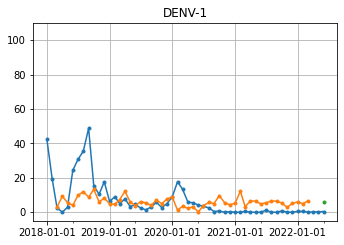

In [ ]:
#using LSTM
method = 'LSTM'
#use other serotypes ratio
train_data = np.array([[np.concatenate([train_data_split[i][j, :], train_data_split[i][j - 2, :], train_data_split[i][j - 1, :]]) for j in range(2, train_data_split[i].shape[0])] for i in range(4)])
# test_data = np.array([[np.concatenate([test_data_split[i][j - 2, :], test_data_split[i][j - 1, :], test_data_split[i][j, :]]) for j in range(2, test_data_split[i].shape[0])] for i in range(4)])
test_data = np.array([[np.concatenate([test_data_split[i][0, :], train_data_split[i][-2, :], train_data_split[i][-1, :]]), 
                       np.concatenate([test_data_split[i][1, :], train_data_split[i][-1, :], test_data_split[i][0, :]])] + 
                      [np.concatenate([test_data_split[i][j, :], test_data_split[i][j - 2, :], test_data_split[i][j - 1, :]]) for j in range(2, test_data_split[i].shape[0])] for i in range(4)])

#not use other serotypes ration
train_data = np.array([[np.concatenate([train_data_dropped_split[i][j, :], train_data_dropped_split[i][j - 2, :], train_data_dropped_split[i][j - 1, :]]) for j in range(2, train_data_dropped_split[i].shape[0])] for i in range(4)])
test_data = np.array([[np.concatenate([test_data_dropped_split[i][j - 2, :], test_data_dropped_split[i][j - 1, :], test_data_dropped_split[i][j, :]]) for j in range(2, test_data_dropped_split[i].shape[0])] for i in range(4)])
# test_data = np.array([[np.concatenate([test_data_dropped_split[i][0, :], train_data_dropped_split[i][-2, :], train_data_dropped_split[i][-1, :]]), 
#                        np.concatenate([test_data_dropped_split[i][1, :], train_data_dropped_split[i][-1, :], test_data_dropped_split[i][0, :]])] + 
#                       [np.concatenate([test_data_dropped_split[i][j, :], test_data_dropped_split[i][j - 2, :], test_data_dropped_split[i][j - 1, :]]) for j in range(2, test_data_split[i].shape[0])] for i in range(4)])

epoch_size = 100
batch_size = 4
logs_lstm = []
predicts_lstm = []
fig = plt.figure(figsize = (12, 8))
modelCheckpoint = ModelCheckpoint(filepath = 'checkpoint/checkpoint_lstm', save_best_only = True, monitor = 'loss', mode = 'min')

for serotype in range(1, 2):
    model = keras.Sequential()
    model.add(layers.LSTM(16, bias_initializer = keras.initializers.he_normal(), input_shape = (train_data[0].shape[1] - 1, 1)))
    model.add(layers.Dense(1))
    # model.summary()

    model.compile(loss = 'mean_squared_error', optimizer = 'Adam', metrics = [metrics.mae])
    
    logs_lstm.append(model.fit(train_data[serotype - 1][:, 1:], train_data[serotype - 1][:, 0], validation_split = 0.05, shuffle = False, epochs = epoch_size, batch_size = batch_size, verbose = 0))
    Predict_train = model.predict(train_data[serotype - 1][:, 1:], batch_size = batch_size, verbose = 1)
    Predict_test = model.predict(test_data[serotype - 1][:, 1:], batch_size = batch_size, verbose = 1)
    predicts_lstm.append(np.concatenate([np.concatenate(Predict_train * 100), np.concatenate(Predict_test * 100)]))
    
    predict_train = pd.DataFrame(Predict_train * 100)
    predict_train.insert(0, 'date', date[2:train_data[serotype - 1].shape[0] + 2])
    predict_train[predict_train.columns[0]] = pd.to_datetime(predict_train[predict_train.columns[0]], format = '%Y-%m')
    
    predict_test = pd.DataFrame(Predict_test * 100)
    predict_test.insert(0, 'date', [f'2022-{i}' for i in range(7 - test_data[serotype - 1].shape[0], 7)]) #testにtrain_data[-2,-1]を入れるときはrange(4,7)
    predict_test[predict_test.columns[0]] = pd.to_datetime(predict_test[predict_test.columns[0]], format = '%Y-%m')

    ax = fig.add_subplot(2, 2, serotype)
    ax.plot(cases[cases.columns[0]], cases[cases.columns[serotype]], marker='.', label = 'real')
    ax.plot(predict_train[predict_train.columns[0]], predict_train[predict_train.columns[1]], marker='.', label = f'prediction-{method}(train)')
    ax.plot(predict_test[predict_test.columns[0]], predict_test[predict_test.columns[1]], marker='.', label = f'prediction-{method}(test)')
    ax.set_xticks(major, minor = False)
    ax.set_xticks(minor, minor = True)
    ax.set_ylim(-5, 110)
    # ax.legend(bbox_to_anchor = (0, 1), loc = 'upper left', borderaxespad = 0.5, fontsize = 12)
    if serotype == 2:
        ax.legend(bbox_to_anchor = (1, 1), loc = 'upper left', borderaxespad = 0.5, fontsize = 12)
    ax.grid()
    ax.set_title(f'DENV-{serotype}')

model.save('drive/MyDrive/dry/modeling/data/Singapore/models/model_lstm', include_optimizer = False)
# plt.tight_layout()
# plt.savefig('lstm.png', dpi = 300)
# files.download('lstm.png')

In [ ]:
import keras
import numpy as np
model_load = keras.models.load_model('drive/MyDrive/dry/modeling/data/Singapore/models/model_lstm')

In [ ]:
test_data[serotype - 1][:, 1:]

[[0.00615894 0.00657143 0.00790698 0.61538462 0.002      0.00384106
  0.01       0.00837209 0.84615385 0.004      0.00317881 0.00657143
  0.0055814  0.57692308]]


In [ ]:
test_data_temp = np.array([[0.00615894, 0.00657143, 0.00790698, 0.61538462, 0.002, 0.00384106,
                  0.01, 0.00837209, 0.84615385, 0.004, 0.00317881, 0.00657143, 
                  0.0055814, 0.57692308]])
test_data_temp

array([[0.00615894, 0.00657143, 0.00790698, 0.61538462, 0.002     ,
        0.00384106, 0.01      , 0.00837209, 0.84615385, 0.004     ,
        0.00317881, 0.00657143, 0.0055814 , 0.57692308]])

In [ ]:
print(model_load.predict(test_data_temp))
temp

[[0.05686095]]


array([[0.05686095]], dtype=float32)

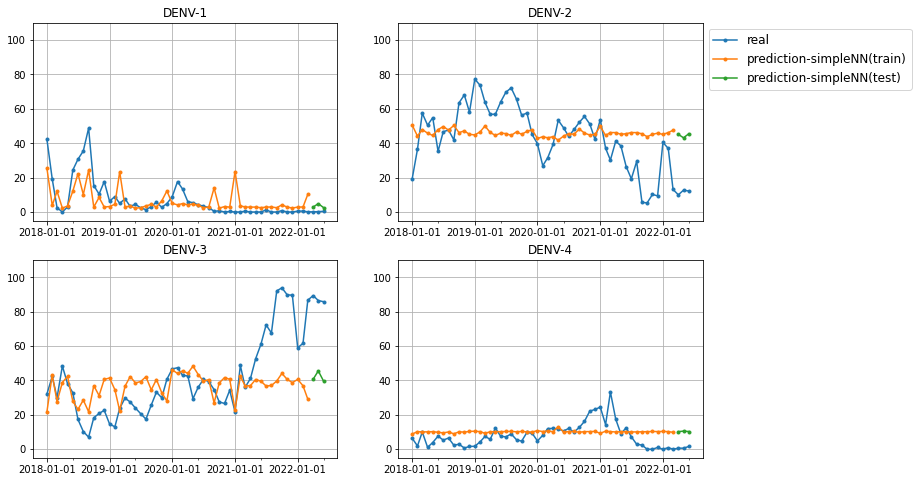

In [ ]:
#using simple NN
method = 'simpleNN'
train_data = train_data_dropped_split
test_data = test_data_dropped_split

epoch_size = 50
batch_size = 2

logs_nn = []
predicts_nn = []

fig = plt.figure(figsize = (12, 8))
modelCheckpoint = ModelCheckpoint(filepath = 'checkpoint/checkpoint_reg', save_best_only = True, monitor = 'loss', mode = 'min', )

for serotype in range(1, 5):
    model = keras.Sequential()
    model.add(layers.Dense(16, bias_initializer = keras.initializers.he_normal(), activation = 'relu', input_dim = train_data[0].shape[1] - 1))
    model.add(layers.Dense(16, bias_initializer = keras.initializers.he_normal(), activation = 'relu'))
    # model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1))
    # model.summary()

    model.compile(loss = 'mean_squared_error', optimizer = 'Adam', metrics = [metrics.mae])
    logs_nn.append(model.fit(train_data[serotype - 1][:, 1:], train_data[serotype - 1][:, 0], shuffle = False, epochs = epoch_size, batch_size = batch_size, validation_split = 0.05, verbose = 0, callbacks = [modelCheckpoint]))
    Predict_train = model.predict(train_data[serotype - 1][:, 1:])
    Predict_test = model.predict(test_data[serotype - 1][:, 1:])
    predicts_nn.append(np.concatenate([np.concatenate(Predict_train * 100), np.concatenate(Predict_test * 100)]))
    
    predict_train = pd.DataFrame(Predict_train * 100)
    predict_train.insert(0, 'date', date[:train_data[serotype - 1].shape[0]])
    predict_train[predict_train.columns[0]] = pd.to_datetime(predict_train[predict_train.columns[0]], format = '%Y-%m')
    
    predict_test = pd.DataFrame(Predict_test * 100)
    predict_test.insert(0, 'date', [f'2022-{i}' for i in range(4, 7)]) #testにtrain_data[-2,-1]を入れるときはrange(4,7)
    predict_test[predict_test.columns[0]] = pd.to_datetime(predict_test[predict_test.columns[0]], format = '%Y-%m')

    ax = fig.add_subplot(2, 2, serotype)
    ax.plot(cases[cases.columns[0]], cases[cases.columns[serotype]], marker='.', label = 'real')
    ax.plot(predict_train[predict_train.columns[0]], predict_train[predict_train.columns[1]], marker='.', label = f'prediction-{method}(train)')
    ax.plot(predict_test[predict_test.columns[0]], predict_test[predict_test.columns[1]], marker='.', label = f'prediction-{method}(test)')
    ax.set_xticks(major, minor = False)
    ax.set_xticks(minor, minor = True)
    ax.set_ylim(-5, 110)
    # ax.legend(bbox_to_anchor = (0, 1), loc = 'upper left', borderaxespad = 0.5, fontsize = 12)
    if serotype == 2:
        ax.legend(bbox_to_anchor = (1, 1), loc = 'upper left', borderaxespad = 0.5, fontsize = 12)
    ax.grid()
    ax.set_title(f'DENV-{serotype}')

# plt.tight_layout()
# plt.savefig('simplenn.png', dpi = 300)
# files.download('simplenn.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

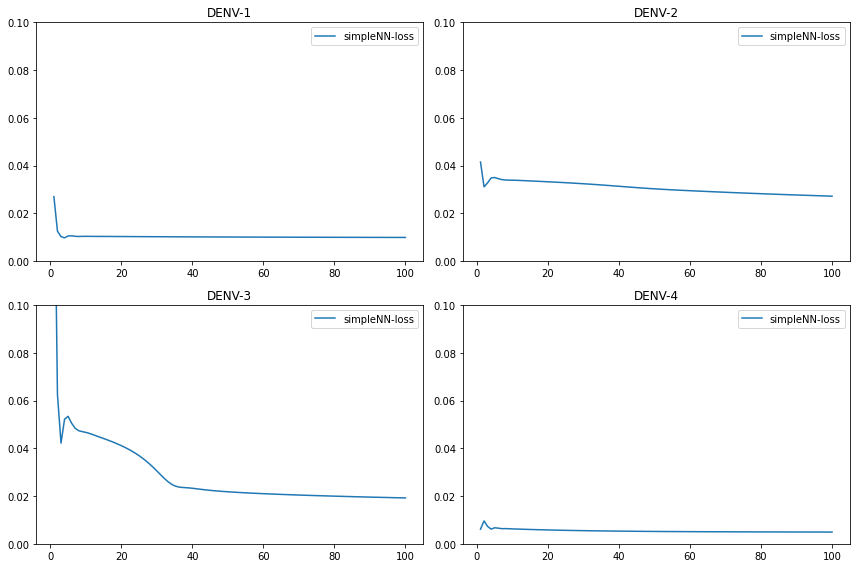

In [ ]:
log = [pd.DataFrame(logs_lstm[i].history) for i in range(4)]
nums = [i for i in range(1, 100 + 1)]
log[0].insert(0, 'epoch', nums)
log[1].insert(0, 'epoch', nums)
log[2].insert(0, 'epoch', nums)
log[3].insert(0, 'epoch', nums)

fig = plt.figure(figsize = (12, 8))
for i in range(1, 5):
    ax = fig.add_subplot(2, 2, i)
    ax.plot(log[i - 1][log[i - 1].columns[0]], log[i - 1][log[i - 1].columns[1]], label = f'{method}-loss')
    # ax.plot(log[i - 1][log[i - 1].columns[0]], log[i - 1][log[i - 1].columns[2]], label = 'MSE')
    if serotype == 2:
        ax.legend(bbox_to_anchor = (1, 1), loc = 'upper left', borderaxespad = 0.5, fontsize = 12)
    ax.set_ylim(0, 0.1)
    ax.legend()
    ax.set_title(f'DENV-{i}')

plt.tight_layout()
plt.savefig(f'loss_{method}.png', dpi = 300)
files.download(f'loss_{method}.png')

In [ ]:
# SVG(model_to_dot(model, dpi = None).create(prog = 'dot', format = 'svg'))

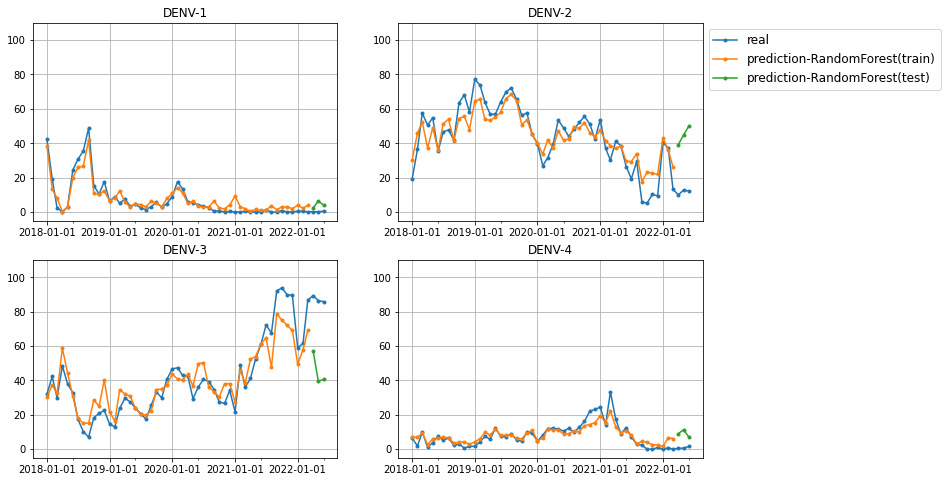

In [ ]:
#using randomforest
method = 'RandomForest'
train_data = train_data_dropped_split
test_data = test_data_dropped_split
fig = plt.figure(figsize = (12, 8))
predicts_rf = []
logs_rf = []

for serotype in range(1, 5):
    forest = RandomForestRegressor()
    forest.fit(train_data[serotype - 1][:, 1:], train_data[serotype - 1][:, 0])

    Predict_train = forest.predict(train_data[serotype - 1][:, 1:])
    Predict_test = forest.predict(test_data[serotype - 1][:, 1:])
    predicts_rf.append(np.concatenate([Predict_train * 100, Predict_test * 100]))
    
    predict_train = pd.DataFrame(Predict_train * 100)
    predict_train.insert(0, 'date', date[:train_data[serotype - 1].shape[0]])
    predict_train[predict_train.columns[0]] = pd.to_datetime(predict_train[predict_train.columns[0]], format = '%Y-%m')
    
    predict_test = pd.DataFrame(Predict_test * 100)
    predict_test.insert(0, 'date', [f'2022-{i}' for i in range(4, 7)]) #testにtrain_data[-2,-1]を入れるときはrange(4,7)
    predict_test[predict_test.columns[0]] = pd.to_datetime(predict_test[predict_test.columns[0]], format = '%Y-%m')
    
    ax = fig.add_subplot(2, 2, serotype)
    ax.plot(cases[cases.columns[0]], cases[cases.columns[serotype]], marker='.', label = 'real')
    ax.plot(predict_train[predict_train.columns[0]], predict_train[predict_train.columns[1]], marker='.', label = f'prediction-{method}(train)')
    ax.plot(predict_test[predict_test.columns[0]], predict_test[predict_test.columns[1]], marker='.', label = f'prediction-{method}(test)')
    ax.set_xticks(major, minor = False)
    ax.set_xticks(minor, minor = True)
    ax.set_ylim(-5, 110)
    # ax.legend(bbox_to_anchor = (0, 1), loc = 'upper left', borderaxespad = 0.5, fontsize = 12)
    if serotype == 2:
        ax.legend(bbox_to_anchor = (1, 1), loc = 'upper left', borderaxespad = 0.5, fontsize = 12)
    ax.grid()
    ax.set_title(f'DENV-{serotype}')

    logs_rf.append(round(mean_squared_error(test_data[serotype - 1][:, 0], Predict_test), 5))

# plt.tight_layout()
# plt.savefig('rf.png', dpi = 300)
# files.download('rf.png')

In [ ]:
logs_rf

[0.00189, 0.11038, 0.17586, 0.0072]

In [ ]:
#using SVM

In [ ]:
#using LightGBM
method = 'LightGBM'
fig = plt.figure(figsize = (12, 8))

params = {'task' : 'train', 'boosting' : 'gbdt', 'objective' : 'regression', 'metric' : 'mse', 'verbose' : -1}

# train_data, test_data = [train_test_split(data[i], shuffle = False, test_size = 0.05)[0] for i in range(4)], [train_test_split(data[i], shuffle = False, test_size = 0.05)[1] for i in range(4)]

# train_data_x, train_data_y = [train_data[i][new_index[i][1:]] for i in range(4)], [train_data[i][new_index[i][0]] for i in range(4)]
# test_data_x, test_data_y = [test_data[i][new_index[i][1:]] for i in range(4)], [test_data[i][new_index[i][0]] for i in range(4)]

train_data = train_data_dropped_split
test_data = test_data_dropped_split

for serotype in range(1, 5):
    print(f'DENV-{serotype}')
    lgb_train = lgb.Dataset(data = train_data[serotype - 1][:48, 1:], label = train_data[serotype - 1][:48, 0], feature_name = new_index[serotype - 1][4:])
    lgb_test = lgb.Dataset(data = train_data[serotype - 1][48:, 1:], label = train_data[serotype - 1][48:, 0], reference=lgb_train)

    model = lgb.train(params, train_set = lgb_train, num_boost_round = 10000, valid_sets = lgb_test, early_stopping_rounds = 50)

    Predict = model.predict(test_data[serotype - 1][:, 1:])
    MAE = mean_squared_error(test_data[serotype - 1][:, 0], Predict)

    predict = pd.DataFrame(Predict * 100)
    predict.insert(0, 'date', [f'2022-{i}' for i in range(4, 7)]) #testにtrain_data[-2,-1]を入れるときはrange(4,7)
    predict[predict.columns[0]] = pd.to_datetime(predict[predict.columns[0]], format = '%Y-%m')

    ax = fig.add_subplot(2, 2, serotype)
    ax.plot(cases[cases.columns[0]], cases[cases.columns[serotype]], marker='.', label = 'real')
    ax.plot(predict[predict.columns[0]], predict[predict.columns[1]], marker='.', label = f'prediction-{method}')
    for i, tick in enumerate(ax.xaxis.get_ticklabels()):
        if i % 3 != 0:
            tick.set_visible(False)
    ax.set_ylim(-5, 110)
    ax.legend(bbox_to_anchor = (0, 1), loc = 'upper left', borderaxespad = 0.5, fontsize = 12)
    ax.grid()
    ax.set_title(f'DENV-{serotype}')

    # lgb.plot_importance(model, figsize = (12, 8))
    # print(f'{MAE})

DENV-2


LightGBMError: ignored

<Figure size 864x576 with 0 Axes>

In [ ]:
# lgb.create_tree_digraph(model, 0)

[参考にしたページ1](https://intellectual-curiosity.tokyo/2019/11/12/keras%E3%82%92%E7%94%A8%E3%81%84%E3%81%9Flstm%E3%81%A7%E3%81%AE%E6%99%82%E7%B3%BB%E5%88%97%E3%83%87%E3%83%BC%E3%82%BF%E4%BA%88%E6%B8%AC/)
[参考にしたページ2](https://qiita.com/everylittle/items/ba821e93d275a421ca2b)
[参考にしたページ3](https://keras.io/api/)

In [ ]:
predict_lasso = pd.concat([pd.Series(date, name = 'date'), pd.DataFrame(predicts_lasso, index = ['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4']).T], axis = 1)
predict_lstm = pd.concat([pd.Series(date[2:51] + [date[-1]], name = 'date'), pd.DataFrame(predicts_lstm, index = ['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4']).T], axis = 1)
predict_nn = pd.concat([pd.Series(date, name = 'date'), pd.DataFrame(predicts_nn, index = ['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4']).T], axis = 1)
predict_rf = pd.concat([pd.Series(date, name = 'date'), pd.DataFrame(predicts_rf, index = ['DENV-1', 'DENV-2', 'DENV-3', 'DENV-4']).T], axis = 1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

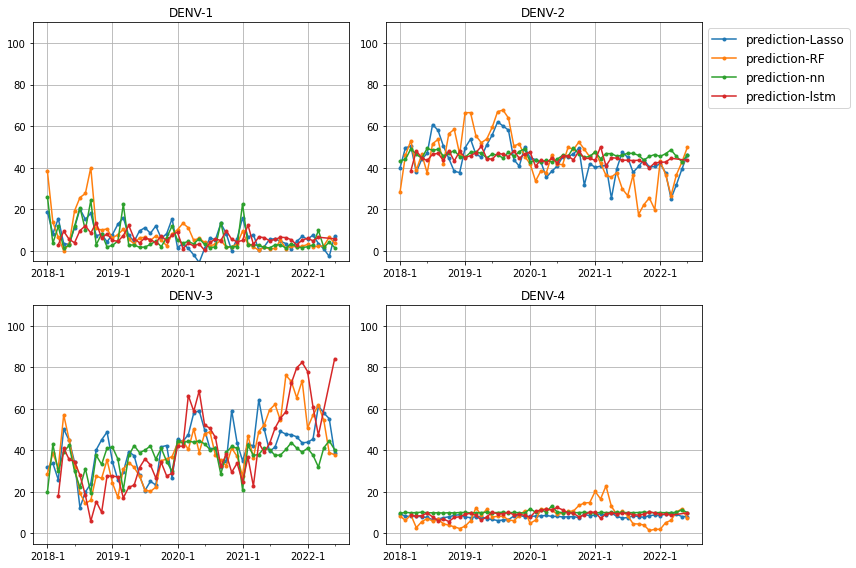

In [ ]:
fig = plt.figure(figsize = (12, 8))
for serotype in range(1, 5):
    ax = fig.add_subplot(2, 2, serotype)
    ax.plot(predict_lasso[predict_lasso.columns[0]], predict_lasso[predict_lasso.columns[serotype]], marker='.', label = 'prediction-Lasso')
    ax.plot(predict_rf[predict_rf.columns[0]], predict_rf[predict_rf.columns[serotype]], marker='.', label = 'prediction-RF')
    ax.plot(predict_nn[predict_nn.columns[0]], predict_nn[predict_nn.columns[serotype]], marker='.', label = 'prediction-nn')
    ax.plot(predict_lstm[predict_lstm.columns[0]], predict_lstm[predict_lstm.columns[serotype]], marker='.', label = 'prediction-lstm')
    
    ax.set_xticks(pd.Series([date[0], date[12], date[24], date[36], date[48]]), minor = False)
    ax.set_xticks(pd.Series([date[5], date[17], date[29], date[41], date[53]]), minor = True)
    # for i, tick in enumerate(ax.xaxis.get_ticklabels()):
    #     if i % 12 != 0:
    #         tick.set_visible(False)
    ax.set_ylim(-5, 110)
    if serotype == 2:
        ax.legend(bbox_to_anchor = (1, 1), loc = 'upper left', borderaxespad = 0.5, fontsize = 12)
    ax.grid()
    ax.set_title(f'DENV-{serotype}')

plt.tight_layout()
plt.savefig('compare.png', dpi = 300)
files.download('compare.png')

In [ ]:
# predict_lstm